In [1]:
#==========Imports==========
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import time
from scipy import interpolate
import Zach_OPTIMIZER.EBMFunctions as opt

import Bell_EBM as ebm

In [2]:
#==========Set Up System==========
planet = ebm.Planet(rad=1.500*const.R_jup.value, mass=1.170*const.M_jup.value,
                    Porb=1.09142030, a=0.02340*2*const.au.value, inc=83.37, vWind=5e3, nlat = 8)
star = ebm.Star(teff=6300., rad=1.59, mass=1.20)
system = ebm.System(star, planet)

In [9]:
def RunTests(star, planet, points, base, basetimes, loops=1):
    """
    Runs several test of a system and returns time 
    to compute and error as comapared to baseline for each test.
    
    Args:
        star (ebm.Star): The star to runs the tests on
        planet (ebm.Planet): The planet to run the tests on
        points (2darray (n by 2)): The array of points to be tested by the model, 
            each point must contain [temporal, spacial], n points are provided
        base (ndarray): Baseline lightcurve as generated by the CreateBaseline function
        basetime (ndarray): Baseline times as generated by CreateBaseline function
        loops (int): Amount of times the function will re-run tests to avergae out the time of computation
        
    Return:
        ndarray: Array of all tested lightcurves
        ndarray: (n by 4), n points of format [temporal, spacial, time_to_compute, error_in_ppm]
    """
    
    data = np.zeros(shape=(points.shape[0],4))
    lcs = np.zeros(shape=(points.shape[0],base.shape[0]))
    _star = star
    _planet = planet
    _system = ebm.System(_star,_planet)
    
    if (_planet.orbit.e != 0):
        phaseBaseline = _system.get_phase(basetimes).flatten()
        order = np.argsort(phaseBaseline)
        baselineLightcurve = base[order]
        phaseBaseline = phaseBaseline[order]
        
    for i in range(0, points.shape[0]):
               
        data[i,0] = points[i,0]
        data[i,1] = points[i,1]
        timeTotal = 0
        
        for j in range (0, loops):
            _star = star
            _planet = planet        
            _planet.map = ebm.Map.Map(nlat=points[i,1])
            _system = ebm.System(_star, _planet)

            tInt = time.time()

            Teq = _system.get_teq()
            T0 = np.ones_like(_system.planet.map.values)*Teq
            t0 = 0.
            t1 = t0+_system.planet.Porb
            dt = _system.planet.Porb/points[i,0]
            testTimes, testMaps = _system.run_model(T0, t0, t1, dt, verbose=False)
            if (_planet.orbit.e != 0):
                T0 = testMaps[-1]
                t0 = testTimes[-1]
                t1 = t0+_system.planet.Porb
                dt = _system.planet.Porb/points[i,0]
                testTimes, testMaps = _system.run_model(T0, t0, t1, dt, verbose=False, intermediates=True)
                testLightcurve = _system.lightcurve(testTimes, testMaps, bolo=False, wav=4.5e-6)

                phaseTest = _system.get_phase(testTimes).flatten()
                order = np.argsort(phaseTest)
                testLightcurve = testLightcurve[order]
                phaseTest = phaseTest[order]
                testLightcurve = np.interp(phaseBaseline, phaseTest, testLightcurve)
            else:
                testLightcurve = _system.lightcurve(bolo=False, wav=4.5e-6)

            tFin = time.time()
            timeTotal += (tFin-tInt)

        lcs[i] = testLightcurve
        data[i,3] = (1e6)*(np.amax(np.absolute(base - testLightcurve)))
        data[i,2] = (timeTotal/loops)*(1e3)

    return lcs, data

In [3]:
p = np.zeros(shape=((15),2))
p[:,1]=16
for i in range(0,15):
    p[i,0] = (i*100)+100
p

array([[ 100.,   16.],
       [ 200.,   16.],
       [ 300.,   16.],
       [ 400.,   16.],
       [ 500.,   16.],
       [ 600.,   16.],
       [ 700.,   16.],
       [ 800.,   16.],
       [ 900.,   16.],
       [1000.,   16.],
       [1100.,   16.],
       [1200.,   16.],
       [1300.,   16.],
       [1400.,   16.],
       [1500.,   16.]])

In [4]:
blt, blm, blc = opt.CreateBaseline(star,planet,spacial=16, orbit=1, temporal=10000)

In [7]:
lcs, data = opt.RunTests(star,planet,p,blc,blt,loops=20)

In [18]:
alphadata = data

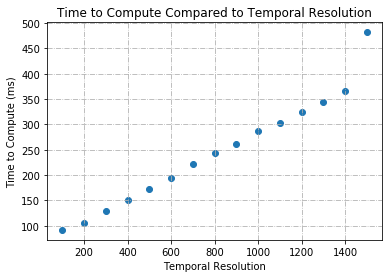

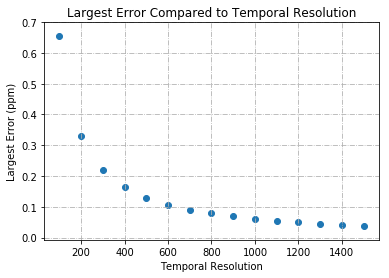

In [6]:
y = data[:,2]
x = data[:,0]
plt.scatter(x, y)
plt.xlabel("Temporal Resolution")
plt.ylabel("Time to Compute (ms)")
plt.title('Time to Compute Compared to Temporal Resolution')
plt.grid(True, linestyle='-.')
plt.show()

y = data[:,3]
x = data[:,0]
plt.scatter(x, y)
plt.xlabel("Temporal Resolution")
plt.ylabel("Largest Error (ppm)")
plt.title('Largest Error Compared to Temporal Resolution')
plt.grid(True, linestyle='-.')
plt.show()

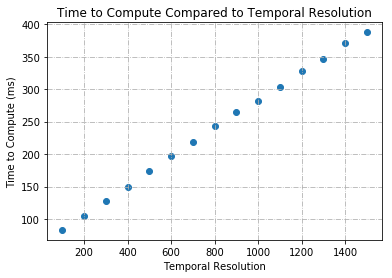

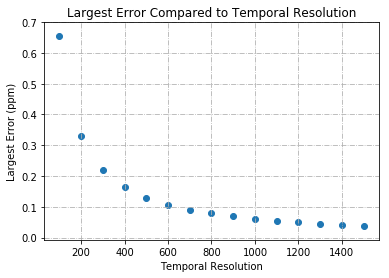

In [8]:
y = data[:,2]
x = data[:,0]
plt.scatter(x, y)
plt.xlabel("Temporal Resolution")
plt.ylabel("Time to Compute (ms)")
plt.title('Time to Compute Compared to Temporal Resolution')
plt.grid(True, linestyle='-.')
plt.show()

y = data[:,3]
x = data[:,0]
plt.scatter(x, y)
plt.xlabel("Temporal Resolution")
plt.ylabel("Largest Error (ppm)")
plt.title('Largest Error Compared to Temporal Resolution')
plt.grid(True, linestyle='-.')
plt.show()

In [49]:
data

array([[1.00000000e+03, 8.00000000e+00, 1.95081949e+02, 4.48975688e-02]])

In [45]:
#==========Set Up System==========
planet = ebm.Planet(rad=1.500*const.R_jup.value, mass=1.170*const.M_jup.value,
                    Porb=1.09142030, a=0.02340*2*const.au.value, inc=83.37, vWind=5e3, nlat = 8)
star = ebm.Star(teff=6300., rad=1.59, mass=1.20)
system = ebm.System(star, planet)
# Run initial burn-in - try guessing the equilibrium temperature to begin with
Teq = system.get_teq()
T0 = np.ones_like(system.planet.map.values)*Teq
t0 = 0.
t1 = t0+system.planet.Porb*1
dt = system.planet.Porb/1000.
times, maps = system.run_model(T0, t0, t1, dt, verbose=False)
blight = system.lightcurve(bolo=False, wav=4.5e-6)

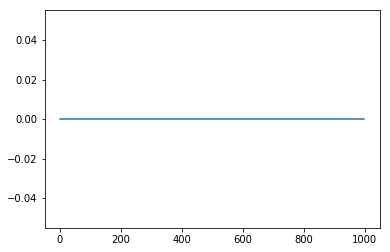

In [48]:
#plt.plot((blight-blc)*1e6)
plt.plot(lcs[0]-blight)

In [23]:
np.amax(np.abs((blight-alight)*1e6))

0.00011364181991269096

In [25]:
np.amax(np.abs((blc-alight)*1e6))

393.6290710125467